In [164]:
import pandas as pd
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
#MSE - test
from sklearn.metrics import mean_squared_error
import seaborn as sns
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [165]:
def inverse_differencing(orig_data, diff_data, interval):
    output = orig_data[:interval].tolist()
    for i in range(interval, len(diff_data)):
        output.append(output[i-interval] + diff_data[i])
    return output

def inverse_differencing_forecast(orig_series, diff_series, forecast_series, interval):
    series_merge = diff_series.append(forecast_series)
    inverse_diff_series = pd.Series(inverse_differencing(orig_series, series_merge, interval), 
                                    index=series_merge.index)
    return inverse_diff_series[-len(forecast_series):]

def train_test_forecast_plot(train_series, test_series, forecast_series, lower_upper=None):
    plt.plot(train_series, label = 'train')
    plt.plot(test_series, label = 'test')
    plt.plot(forecast_series, label = 'forecast')
    plt.plot(figsize=(20,10))

    if lower_upper is not None:
        plt.fill_between(lower_upper[0].index, lower_upper[0], 
                     lower_upper[1], color='k', alpha=.15)
    plt.legend()

In [166]:
# Pepare data
pre_data = pd.read_csv('preprocessed_data.csv')
pre_data = pre_data.drop(['holiday', 'temp_mean'], axis=1)
pre_data = pre_data[:-1]
pre_data.head()

,date,total_power_consumption
0,2011-11-23,90.39
1,2011-11-24,213.41
2,2011-11-25,303.99
3,2011-11-26,420.98
4,2011-11-27,444.88


<AxesSubplot:>

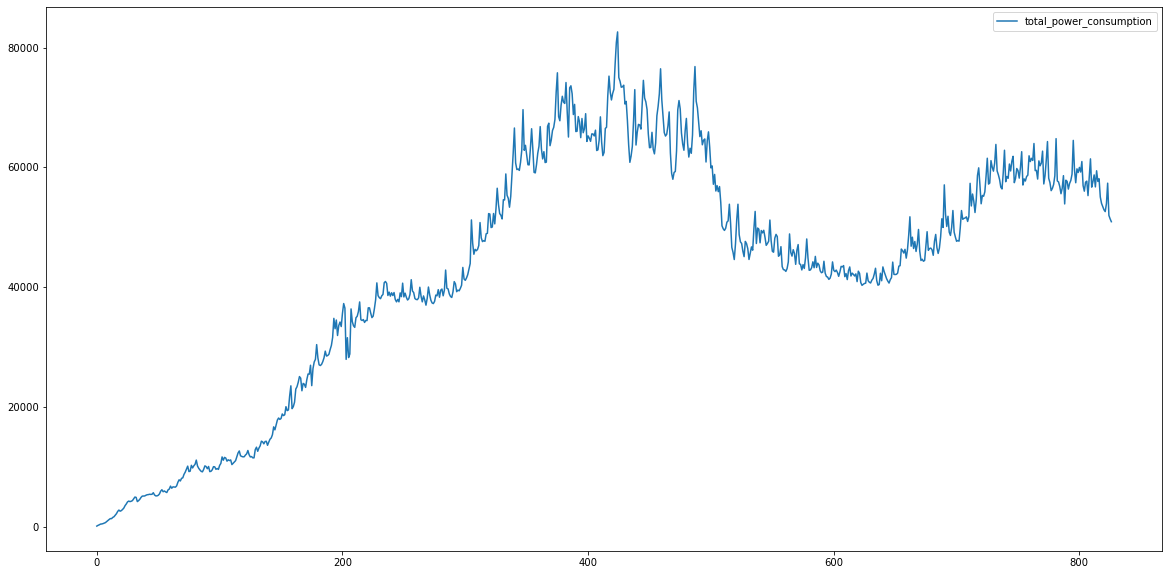

In [167]:
# plot time series graph of power consumption
pre_data.plot(figsize=(20,10))

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

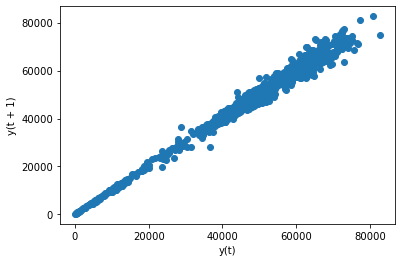

In [168]:
# lag plot 
lag_plot(pre_data['total_power_consumption'], lag=1)
# Strong Correlation

In [175]:
# AR MA ARIMA

In [176]:
date_data = pd.read_csv('preprocessed_data.csv')['date']
date_data = date_data[:-1]
date_data.shape

(827,)

In [177]:
# Pepare data
pre_data = pd.read_csv('preprocessed_data.csv')
# setting date as index column
pre_data_series = pd.Series(pre_data['total_power_consumption'].values, index=pre_data['date'].values)
pre_data_series = pre_data_series[:-1]
pre_data_series

2011-11-23       90.39
2011-11-24      213.41
2011-11-25      303.99
2011-11-26      420.98
2011-11-27      444.88
                ...   
2014-02-22    53945.87
2014-02-23    57379.09
2014-02-24    51994.55
2014-02-25    51423.51
2014-02-26    50943.31
Length: 827, dtype: float64

In [178]:
# generate time plot
def generate_time_plot(x1, y1, x2=None, y2=None, overlay=False, title="Time Plot", label2=None, xlabel="time", ylabel="data"):
    """
    Display a time plot of x1 versus y1 with the respective x-axis and y-axis labels.
    If overlay is True, x2 and y2 arguments need to be supplied to plot an overlay time plot.
    """
    plt.figure(figsize=(14,7))
    plt.plot(x1, y1, 'k-', label="data", color='green', linewidth=1)
    if overlay:
        plt.plot(x2, y2, 'b-', label=label2, color='red', linewidth=1)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.5)
    plt.legend();

In [179]:
train = 828*80/100 # 663
test = 828 - 663
test

165

In [180]:
# train 70 - test 30split 
power_train = pre_data_series[:-test]
date_train = date_data[:-test]
power_test = pre_data_series[-test:]
date_test = date_data[-test:]

In [181]:
# adf
def print_adf_result(adf_result):
    df_results = pd.Series(adf_result[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    
    for key, value in adf_result[4].items():
        df_results['Critical Value (%s)'% key] = value
    print('Augmented Dickey-Fuller Test Results:')
    print(df_results)
    

result = adfuller(power_train, maxlag=12)
print_adf_result(result)
# p value larger than 0.05 = not stationary 

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -1.996123
P-Value                   0.288276
# Lags Used              11.000000
# Observations Used     650.000000
Critical Value (1%)      -3.440450
Critical Value (5%)      -2.865997
Critical Value (10%)     -2.569143
dtype: float64


Text(0.5, 1.0, 'power usage')

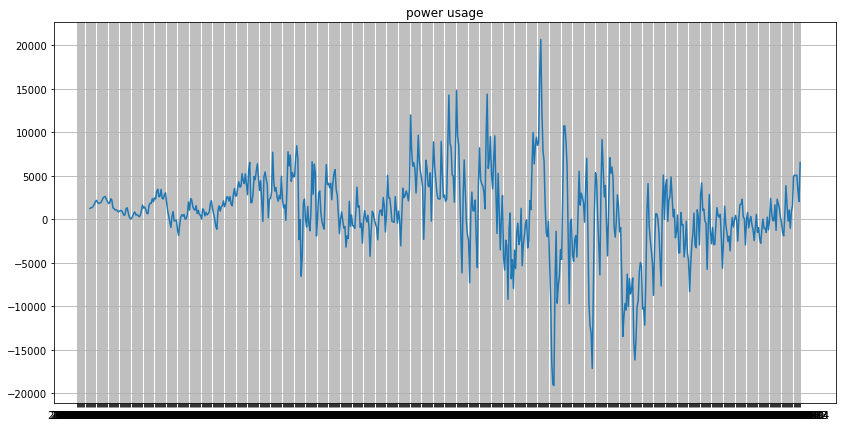

In [182]:
# seasonal differencing
power_train_diff = power_train.diff(12)

# plot time plot
plt.figure(figsize=(14,7))
plt.grid()
plt.plot(power_train_diff)
plt.title('power usage')

In [183]:
# diff test
power_test_diff = power_test.diff(12)

In [184]:
# ADF again
result = adfuller(power_train_diff.dropna())
print_adf_result(result)
# p value lower than 0.05 = obtain stationary

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -4.600162
P-Value                   0.000129
# Lags Used              19.000000
# Observations Used     630.000000
Critical Value (1%)      -3.440772
Critical Value (5%)      -2.866139
Critical Value (10%)     -2.569219
dtype: float64


AR(1)
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  650
Model:                     ARMA(1, 0)   Log Likelihood               -6082.360
Method:                       css-mle   S.D. of innovations           2801.218
Date:                Sun, 04 Apr 2021   AIC                          12170.720
Time:                        21:43:12   BIC                          12184.151
Sample:                    12-05-2011   HQIC                         12175.930
                         - 09-14-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        816.0052    502.619      1.624      0.104    -169.109    1801.119
ar.L1.y        0.7826      0.024     32.127      0.000       0.735       0.830
                                    Roots     

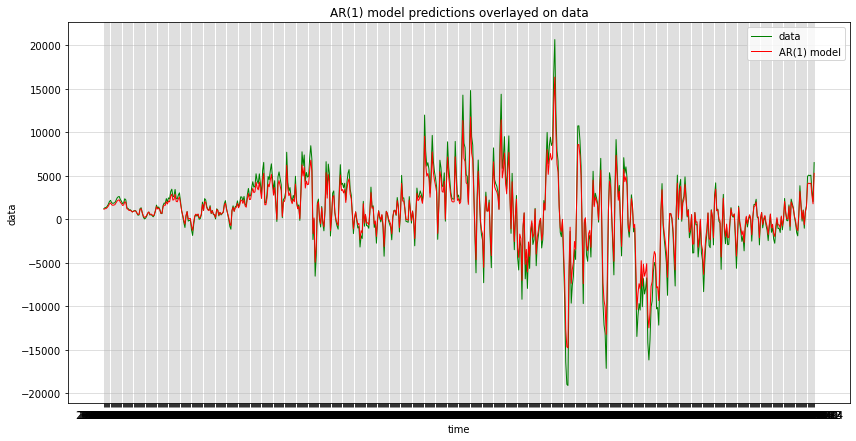

In [185]:
# AR
# for p in range(1,6):
model = ARMA(power_train_diff[12:], (1,0)).fit()
ar_pred = model.predict(start=1, end=power_train_diff[12:].shape[0])
generate_time_plot(date_train[12:], power_train_diff[12:], date_train[12:], model.predict(start=1, end=power_train_diff[12:].shape[0]), overlay=True, 
               title=f"AR({1}) model predictions overlayed on data", label2=f"AR({1}) model")
print(f"AR({1})")
print(model.summary())
print("\n\n")

In [186]:
rmse = mean_squared_error(power_train_diff[12:], ar_pred, squared=False)
print('Train RMSE: ', rmse)

Train RMSE:  978.7157103284396


MA(1)
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  650
Model:                     ARMA(0, 1)   Log Likelihood               -6156.016
Method:                       css-mle   S.D. of innovations           3137.426
Date:                Sun, 04 Apr 2021   AIC                          12318.032
Time:                        21:43:17   BIC                          12331.463
Sample:                    12-05-2011   HQIC                         12323.242
                         - 09-14-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        816.0495    217.924      3.745      0.000     388.927    1243.172
ma.L1.y        0.7721      0.024     32.341      0.000       0.725       0.819
                                    Roots     

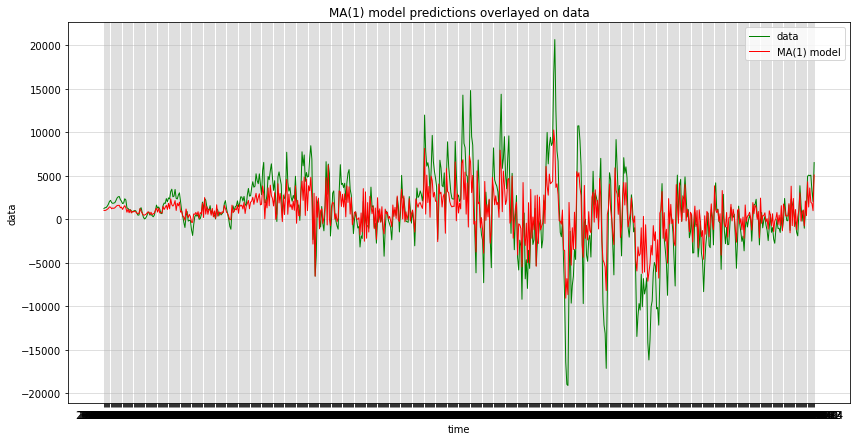

In [188]:
# MA
# plot different orders (q's)  
model = ARMA(power_train_diff[12:], (0,1)).fit()
ma_pred = model.predict(start=1, end=power_train_diff[12:].shape[0])
generate_time_plot(date_train[12:], power_train_diff[12:], date_train[12:], model.predict(start=1, end=power_train_diff[12:].shape[0]), overlay=True, 
               title=f"MA({1}) model predictions overlayed on data", label2=f"MA({1}) model")
print(f"MA({1})")
print(model.summary())
print("\n\n")

In [189]:
rmse = mean_squared_error(power_train_diff[12:], ma_pred, squared=False)
print('Train RMSE: ', rmse)

Train RMSE:  2719.4937241484367


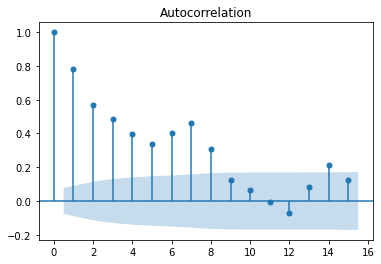

In [190]:
# plot ACF plot -> MA
plot_acf(power_train_diff.dropna(), lags=range(0,16));

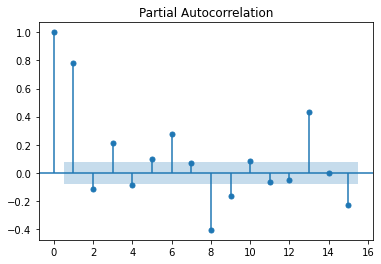

In [191]:
# plot PACF plot -> AR
plot_pacf(power_train_diff.dropna(), lags=range(0,16));

In [192]:
# fitting ARIMA model
arima = ARIMA(power_train_diff.dropna(), order=(8,0,7)).fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  650
Model:                     ARMA(8, 7)   Log Likelihood               -5854.936
Method:                       css-mle   S.D. of innovations           1938.250
Date:                Sun, 04 Apr 2021   AIC                          11743.872
Time:                        21:43:39   BIC                          11819.981
Sample:                    12-05-2011   HQIC                         11773.393
                         - 09-14-2013                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        816.0675    540.530      1.510      0.131    -243.351    1875.486
ar.L1.y        2.0453      0.038     53.812      0.000       1.971       2.120
ar.L2.y       -2.1589      0.075    -28.786      0.000      -2.306      -2.012
ar.L3.y        1.3764      0.093     14.810      0.000       1.194       1.559
ar.L4.y       -0.3803      0.101     -3.747      0.000      -0.579      -0.181
ar.L5.y       -0.7938      0.101     -7.892      0.000      -0.991      -0.597
ar.L6.y        1.6566      0.090     18.386      0.000       1.480       1.833
ar.L7.y       -1.3640      0.072    -18.988      0.000      -1.505      -1.223
ar.L8.y        0.4396      0.037     11.886      0.000       0.367       0.512
ma.L1.y       -1.2966      0.021    -60.747      0.000      -1.338      -1.255
ma.L2.y        1.1869      0.037     31.723      0.000       1.114       1.260
ma.L3.y       -0.1943      0.032     -6.027      0.000      -0.257      -0.131
ma.L4.y       -0.3429      0.028    -12.122      0.000      -0.398      -0.287
ma.L5.y        1.1866      0.038     31.481      0.000       1.113       1.260
ma.L6.y       -1.2025      0.031    -38.976      0.000      -1.263      -1.142
ma.L7.y        0.9457      0.016     57.672      0.000       0.914       0.978
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1132           -0.0000j            1.1132           -0.5000
AR.2           -0.2246           -0.9769j            1.0023           -0.2860
AR.3           -0.2246           +0.9769j            1.0023            0.2860
AR.4            0.6259           -0.8319j            1.0411           -0.1474
AR.5            0.6259           +0.8319j            1.0411            0.1474
AR.6            1.0645           -0.5726j            1.2088           -0.0785
AR.7            1.0645           +0.5726j            1.2088            0.0785
AR.8            1.2843           -0.0000j            1.2843           -0.0000
MA.1           -1.0000           -0.0000j            1.0000           -0.5000
MA.2           -0.2327           -1.0016j            1.0282           -0.2863
MA.3           -0.2327           +1.0016j            1.0282            0.2863
MA.4            0.8646           -0.5027j            1.0001           -0.0838
MA.5            0.8646           +0.5027j            1.0001            0.0838
MA.6            0.5039           -0.8637j            1.0000           -0.1659
MA.7            0.5039           +0.8637j            1.0000            0.1659
-----------------------------------------------------------------------------
"""

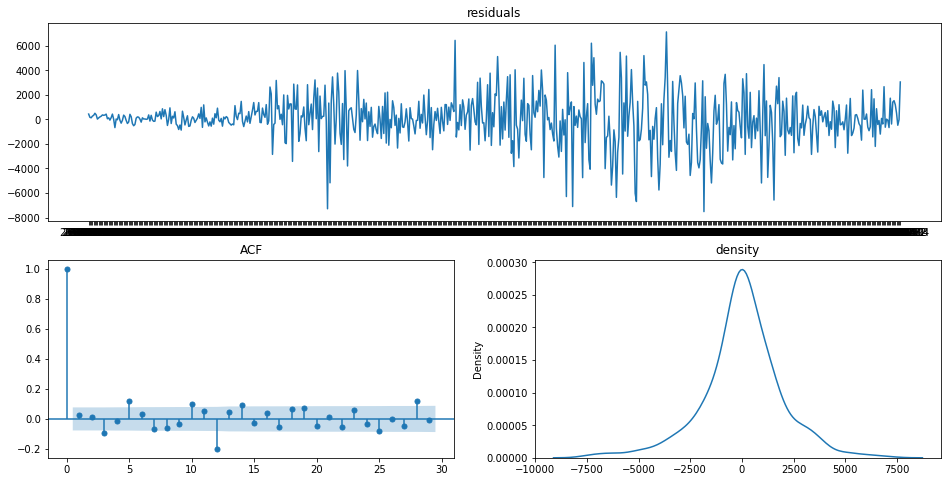

In [193]:
residuals = pd.Series(arima.resid)
def check_residuals(series):
    fig = plt.figure(figsize=(16, 8))    
    gs = fig.add_gridspec(2,2)
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(series)
    ax1.set_title('residuals')
    
    ax2 = fig.add_subplot(gs[1,0])
    plot_acf(series, ax=ax2, title='ACF')
    
    ax3 = fig.add_subplot(gs[1,1])
    sns.kdeplot(series, ax=ax3)
    ax3.set_title('density')
    
    plt.show()
    
check_residuals(residuals)

In [194]:
# Prediction test
arima_forecast_test, se, conf = arima.forecast(test)

arima_forecast = pd.Series(arima_forecast, index=power_test.index)
lower_series = pd.Series(conf[:, 0], index=power_test.index)
upper_series = pd.Series(conf[:, 1], index=power_test.index)

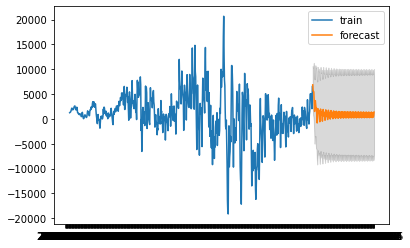

In [195]:
plt.plot(power_train_diff, label='train')
plt.plot(arima_forecast, label='forecast')

plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.legend()

In [196]:
def inverse_differencing(orig_data, diff_data, interval):
    output = orig_data[:interval].tolist()
    for i in range(interval, len(diff_data)):
        output.append(output[i-interval] + diff_data[i])
    return output

def inverse_differencing_forecast(orig_series, diff_series, forecast_series, interval):
    series_merge = diff_series.append(forecast_series)
    inverse_diff_series = pd.Series(inverse_differencing(orig_series, series_merge, interval), 
                                    index=series_merge.index)
    return inverse_diff_series[-len(forecast_series):]

def train_test_forecast_plot(train_series, test_series, forecast_series, lower_upper=None):
    plt.plot(train_series, label = 'train')
    plt.plot(test_series, label = 'test')
    plt.plot(forecast_series, label = 'forecast')

    if lower_upper is not None:
        plt.fill_between(lower_upper[0].index, lower_upper[0], 
                     lower_upper[1], color='k', alpha=.15)
    plt.legend()

In [197]:
# inverse differenced series back to original series
forecast_series = inverse_differencing_forecast(power_train, power_train_diff, arima_forecast, 12)
lower_series = inverse_differencing_forecast(power_train, power_train_diff, lower_series, 12)
upper_series = inverse_differencing_forecast(power_train, power_train_diff, upper_series, 12)

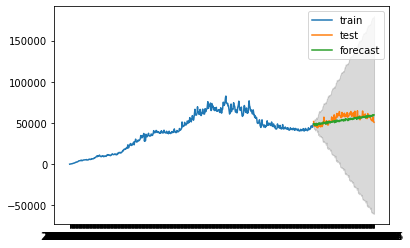

In [198]:
train_test_forecast_plot(power_train, power_test, forecast_series, 
                         [lower_series, upper_series])

In [199]:
#MSE - test
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(power_test, forecast_series, squared=False)
print('Test RMSE: ', rmse)

Test RMSE:  4278.995444516385


In [200]:
# Grid search

In [201]:
# # train 70 - test 30split 
# power_train = pre_data_series[:-test]
# power_test = pre_data_series[-test:]

In [202]:
# # seasonal differencing
# power_train_diff = power_train.diff(12)

# # plot time plot
# plt.figure(figsize=(14,7))
# plt.grid()
# plt.plot(power_train_diff)
# plt.title('power usage')

In [203]:
# # Grid Search
# # Data - dif= 12 (deseason)
# param_p = [0,1,2,3,4,5,6, 7, 8]
# param_d = [0,1,2] # ARIMA only support two times of differencing
# param_q = [0,1,2,3,4,5,6, 7, 8]

# best_error, best_params, best_model = None, None, None

# for p in param_p:
#     for d in param_d:
#         for q in param_q:
#             try:
#                 arima = ARIMA(power_train_diff.dropna(), order=(p,d,q)).fit()
#                 if best_error is None or arima.aic < best_error:
#                     best_error = arima.aic
#                     best_params = (p,d,q)
#                     best_model = arima
#                 print('ARIMA({},{},{}), AIC={}'.format(p,d,q, arima.aic))
#             except:
#                 pass
# print('Best Error={}, Best Params={}'.format(best_error, best_params))

In [204]:
# # Grid Search
# # Data - dif= 1 (detrend)
# param_p = [0,1,2,3,4,5,6, 7, 8, 9, 10]
# param_d = [0,1,2] # ARIMA only support two times of differencing
# param_q = [0,1,2,3,4,5,6, 7, 8, 9, 10]

# best_error, best_params, best_model = None, None, None

# for p in param_p:
#     for d in param_d:
#         for q in param_q:
#             try:
#                 arima = ARIMA(power_train_diff.dropna(), order=(p,d,q)).fit()
#                 if best_error is None or arima.aic < best_error:
#                     best_error = arima.aic
#                     best_params = (p,d,q)
#                     best_model = arima
#                 print('ARIMA({},{},{}), AIC={}'.format(p,d,q, arima.aic))
#             except:
#                 pass
# print('Best Error={}, Best Params={}'.format(best_error, best_params))